# *The Minority Report*
## Christopher Yi, Rohit Barua, Shafiullah Hashimi, Jim Banya
## CS 484-002 :: Data Mining
## George Mason University, Spring 2023, Professor Ziwei Zhu


This notebook will analyze various datasets with regards to minority representation across various industries, with an additional focus on STEM fields. The primary goal is to find discrepancies in representative statistics between the raw data and those yielded from data mining algorithms.

## Christopher
The following historical data will be used to illustrate differences between the proportions of racially-classified "professionals" (college graduates) against the race-based percentage of the population in 2011 (the year chosen as this had the most complete employment records across all industries). The ratios of professionals is taken from the United States Equal Employment Opportunity Commission's statistics on employees across all industries in all 51 states/territories, while the race-based percentages of the population are calculated from United States Census records.

This is not meant to demonstrate data mining techniques, but rather to provide some historical background on race-based discrepancies in hiring.

In [128]:
import numpy as np
import pandas as pd
from tqdm import tqdm

cols = ['State', 'nac2Label', 'totProf/StInd',  
        'whiteProfessionalTotal', 'blackProfessionalTotal', 'hispanicOrLatinoProfessionalTotal', 
        'asianProfessionalTotal', 'americIndianProfessionalTotal', 'pacificIslanderProfessionalTotal']

df = pd.read_csv("inputs/CountByStateAndIndustryNAC-2.csv", usecols=cols, nrows=957)

df = df.loc[(df['nac2Label'] == 'Information') | (df['nac2Label'] == 'Professional, Scientific, and Technical Services')]

df = df.drop(columns=['nac2Label'])

df = df.groupby('State', sort=True).sum(numeric_only=True)

df = df.rename(columns={'totProf/StInd': 'Total Professionals', 'whiteProfessionalTotal': 'White Professionals',
                       'blackProfessionalTotal': 'Black Professionals', 'hispanicOrLatinoProfessionalTotal': 'Hispanic Professionals',
                       'asianProfessionalTotal': 'Asian Professionals', 'americIndianProfessionalTotal': 'American Indian Professionals',
                       'pacificIslanderProfessionalTotal': 'Pacific Islander Professionals'})

df

,Total Professionals,White Professionals,Black Professionals,Hispanic Professionals,Asian Professionals,American Indian Professionals,Pacific Islander Professionals
State,,,,,,,
Alabama,62826,52011,4182,3467,755,2167,38
Alaska,2827,2381,156,103,65,82,13
Arizona,22336,16609,787,2030,2417,151,76
Arkansas,5834,4658,436,94,561,21,6
California,277600,156349,8761,20929,84493,835,1531
Colorado,51776,43086,1501,2921,3335,210,105
Connecticut,21139,16107,979,810,3061,35,27
Delaware,2858,2132,285,76,321,6,6
District of Columbia,36907,26005,4790,1441,4011,79,67


In [129]:
true_prop_2011 = np.array([.628, .123, .169, .049, .007, .002]) # Adapted from non-CSV charts of 2011 population estimates

np.set_printoptions(precision=5, suppress=True)
state_profs = df.values[:,1:7].astype(float)
state_totals = df.values[:,0]

total_prof = state_totals.sum()

prop = np.zeros((6)).astype(float)

for i in range(state_profs.shape[1]):
    prop[i] = state_profs[:, i].sum() / total_prof

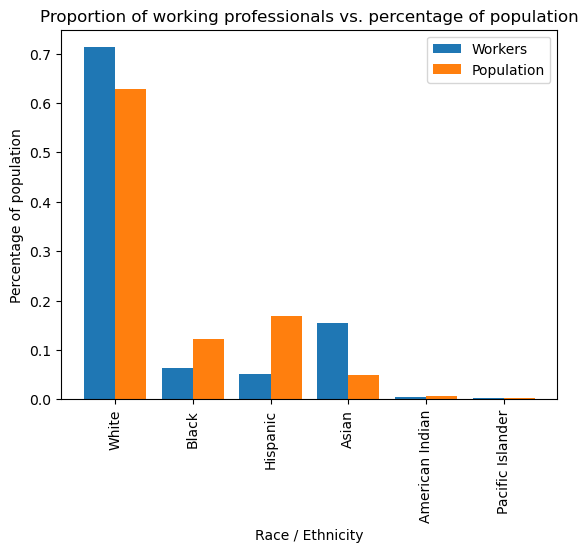

In [130]:
import matplotlib.pyplot as plt

X = ['White', 'Black', 'Hispanic', 'Asian', 'American Indian', 'Pacific Islander']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, prop, 0.4, label = 'Workers')
plt.bar(X_axis + 0.2, true_prop_2011, 0.4, label = 'Population')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Race / Ethnicity")
plt.ylabel("Percentage of population")
plt.title("Proportion of working professionals vs. percentage of population")
plt.legend()

plt.show()

The disparities shown above, although limited in scope to what the EEOC was able to quantify, does seem to demonstrate that white graduates are oversampled across the totality of the data's STEM related fields, while black and Hispanic candidates are extremely undersampled. A key difference is in the additional oversampling of Asian college graduates in the workforce, one that we will revisit later on.

In [131]:
import seaborn as sns

df = pd.read_csv('inputs/HRDataset_v13.csv')
df.dropna(how='all', inplace=True)
df.RaceDesc.name = 'Racial Group'
display(df.RaceDesc.value_counts(), df.RaceDesc.value_counts(normalize=True) * 100)

White                               193
Black or African American            57
Asian                                34
Two or more races                    18
American Indian or Alaska Native      4
Hispanic                              4
Name: Racial Group, dtype: int64

White                               62.258065
Black or African American           18.387097
Asian                               10.967742
Two or more races                    5.806452
American Indian or Alaska Native     1.290323
Hispanic                             1.290323
Name: Racial Group, dtype: float64

Next we will isolate only the purely quantitative features of the dataset regarding each employee, including a race-based ground truth label. In addition, we will only examine "Active" employees, as the other statuses were too few and far between to make any real statistical impact through analysis.

In [132]:
df = df[df['EmploymentStatus'] == 'Active']
relevant_info = ['RaceDesc', 'GenderID',
                 'PerfScoreID', 'EngagementSurvey']
display(df[relevant_info])

,RaceDesc,GenderID,PerfScoreID,EngagementSurvey
0,Black or African American,0.0,3.0,2.04
1,Black or African American,1.0,3.0,5.00
2,White,1.0,3.0,3.90
4,White,0.0,3.0,5.00
7,White,0.0,3.0,5.00
...,...,...,...,...
298,White,1.0,3.0,3.84
299,White,0.0,3.0,5.00
300,Asian,0.0,3.0,5.00
308,White,1.0,3.0,5.00


For classification purposes, each of the recorded racial groups will be coded to an integer value.

In [133]:
df.replace('Black or African American', 0.0, inplace=True)
df.replace('White', 1.0, inplace=True)
df.replace('Asian', 2.0, inplace=True)
df.replace('Hispanic', 3.0, inplace=True)
df.replace('Two or more races', 4.0, inplace=True)
df.replace('American Indian or Alaska Native', 5.0, inplace=True)
display(df[relevant_info])

,RaceDesc,GenderID,PerfScoreID,EngagementSurvey
0,0.0,0.0,3.0,2.04
1,0.0,1.0,3.0,5.00
2,1.0,1.0,3.0,3.90
4,1.0,0.0,3.0,5.00
7,1.0,0.0,3.0,5.00
...,...,...,...,...
298,1.0,1.0,3.0,3.84
299,1.0,0.0,3.0,5.00
300,2.0,0.0,3.0,5.00
308,1.0,1.0,3.0,5.00


Next, we will separate the features from the number-coded ground truth labels, and then partition each in the same manner into training and validation sets in a 4 to 1 ratio.

In [134]:
features = df[relevant_info].values[:, 1:4]
labels = df[relevant_info].values[:, 0].astype(int)
print('array of labels: shape ' + str(np.shape(labels)))
print('array of feature matrix: shape ' + str(np.shape(features)))

array of labels: shape (182,)
array of feature matrix: shape (182, 3)


In [135]:
val_features, train_features = np.split(features, [int(0.2 * features.shape[0])])

val_labels, train_labels = np.split(labels, [int(0.2 * labels.shape[0])])

print(np.shape(train_features))
print(np.shape(val_features))

print(np.shape(train_labels))
print(np.shape(val_labels))

(146, 3)
(36, 3)
(146,)
(36,)


We will now perform a KNN algorithm to the data, using the 2 nearest neighbors as a baseline to start.

In [136]:
def KNN(train_features, train_labels, test_features, k=2):
    preds = []
    for i in tqdm(range(test_features.shape[0])):
        dist = np.sum(np.square(test_features[i] - train_features), axis=1)
        near_ind = np.argpartition(dist, k)[:k]
        near_lab = list(train_labels[near_ind])
        pred = max(near_lab, key=near_lab.count)
        preds.append(pred)
    return np.array(preds)

val_preds = KNN(train_features, train_labels, val_features)
print(val_preds.shape)

100%|██████████| 36/36 [00:00<00:00, 5923.00it/s]

(36,)


In [137]:
# Function copied from Professor Zhu HW1
def evaluation(true, pred):
    acc = np.sum(pred == true) / len(true)

    micro_TP = 0
    micro_FP = 0
    micro_FN = 0
    micro_TN = 0
    macro_F1 = []

    for c in range(6):
        c_label_pos = (true == c)
        c_label_neg = ~c_label_pos
        c_pred_pos = (pred == c)
        c_pred_neg = ~c_pred_pos

        TP = np.sum(c_label_pos * c_pred_pos)
        FP = np.sum(c_label_neg * c_pred_pos)
        FN = np.sum(c_label_pos * c_pred_neg)
        TN = np.sum(c_label_neg * c_pred_neg)

        if TP == 0:
            precision = 0
            recall = 0
            F1 = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            F1 = 2 * precision * recall / (precision + recall)
        macro_F1.append(F1)

        micro_TP += TP
        micro_FP += FP
        micro_TN += TN
        micro_FN += FN

    macro_F1 = np.mean(macro_F1)
    micro_precision = micro_TP / (micro_TP + micro_FP)
    micro_recall = micro_TP / (micro_TP + micro_FN)
    micro_F1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)

    print('accuracy = %.6f' % acc)
    print('macro F1 = %.6f' % macro_F1)
    print('micro F1 = %.6f' % micro_F1)
    
evaluation(val_labels, val_preds)

accuracy = 0.388889
macro F1 = 0.192761
micro F1 = 0.388889


The purely quantitative metrics yield classification results that are evidently very poor predictors for racial identity. However, this is not enough to say that there is a systemic problem in and of itself given that this is simulated data of comparatively small size. The discussion will likely be more fruitful by examining a much larger real world dataset with more scalable values. The following dataset is acquired from a large repository concerned with salaries in data science and other STEM fields. Given that this dataset included a very significant proportion of null responses, they will be treated as "unknown" in the following aggregation, but will be removed later. This is an unfortunate consequence but necessary given the analysis is focused on known identifiers.

In [138]:
df = pd.read_csv('inputs/Levels_Fyi_Salary_Data.csv')
df = df[['gender', 'Race', 'company', 'title', 'yearsofexperience', 
         'yearsatcompany', 'Education', 'totalyearlycompensation']]
df = df.fillna({'gender':'Unknown', 'Race':'Unknown', 'company':'Unknown', 'Education':'Unknown'})
df = df.rename(columns = {'gender':'Gender', 'company':'Company', 'title':'Position', 
                          'yearsofexperience':'Years of Experience', 'yearsatcompany':'Years at Company', 
                          'totalyearlycompensation':'Annual Compensation'})
display(df)
df['Position'].unique()

,Gender,Race,Company,Position,Years of Experience,Years at Company,Education,Annual Compensation
0,Unknown,Unknown,Oracle,Product Manager,1.5,1.5,Unknown,127000
1,Unknown,Unknown,eBay,Software Engineer,5.0,3.0,Unknown,100000
2,Unknown,Unknown,Amazon,Product Manager,8.0,0.0,Unknown,310000
3,Unknown,Unknown,Apple,Software Engineering Manager,7.0,5.0,Unknown,372000
4,Unknown,Unknown,Microsoft,Software Engineer,5.0,3.0,Unknown,157000
...,...,...,...,...,...,...,...,...
62637,Unknown,Unknown,Google,Software Engineer,10.0,1.0,Unknown,327000
62638,Unknown,Unknown,Microsoft,Software Engineer,2.0,2.0,Unknown,237000
62639,Unknown,Unknown,MSFT,Software Engineer,14.0,12.0,Unknown,220000
62640,Unknown,Unknown,Salesforce,Software Engineer,8.0,4.0,Unknown,280000


array(['Product Manager', 'Software Engineer',
       'Software Engineering Manager', 'Data Scientist',
       'Solution Architect', 'Technical Program Manager',
       'Human Resources', 'Product Designer', 'Marketing',
       'Business Analyst', 'Hardware Engineer', 'Sales', 'Recruiter',
       'Mechanical Engineer', 'Management Consultant'], dtype=object)

After this postprocessing, the unique positions informs us that there are non-STEM and CS-related occupations we can remove. We will keep any positions that can tenuously be linked to a CS or STEM field.

In [139]:
df = df[(df['Position'].str.contains('Human Resources') == False)]
df = df[(df['Position'].str.contains('Marketing') == False)]
df = df[(df['Position'].str.contains('Business Analyst') == False)]
df = df[(df['Position'].str.contains('Sales') == False)]
df = df[(df['Position'].str.contains('Recruiter') == False)]
display(df)

,Gender,Race,Company,Position,Years of Experience,Years at Company,Education,Annual Compensation
0,Unknown,Unknown,Oracle,Product Manager,1.5,1.5,Unknown,127000
1,Unknown,Unknown,eBay,Software Engineer,5.0,3.0,Unknown,100000
2,Unknown,Unknown,Amazon,Product Manager,8.0,0.0,Unknown,310000
3,Unknown,Unknown,Apple,Software Engineering Manager,7.0,5.0,Unknown,372000
4,Unknown,Unknown,Microsoft,Software Engineer,5.0,3.0,Unknown,157000
...,...,...,...,...,...,...,...,...
62637,Unknown,Unknown,Google,Software Engineer,10.0,1.0,Unknown,327000
62638,Unknown,Unknown,Microsoft,Software Engineer,2.0,2.0,Unknown,237000
62639,Unknown,Unknown,MSFT,Software Engineer,14.0,12.0,Unknown,220000
62640,Unknown,Unknown,Salesforce,Software Engineer,8.0,4.0,Unknown,280000


The "unknown" monikers will be of little use, so any samples with said values in the dataframe in columns that are about to be examined will be culled. In the following cell, a one-hot encoding for gender will be added to replace the 'gender' column in the dataframe, and will also remove any non-binary identifiers for simplicity.

In [140]:
one_hot_gender = pd.get_dummies(df['Gender'])
df_sex = df.drop('Gender', axis = 1)
df_sex = one_hot_gender.join(df_sex)
df_sex = df_sex[(df_sex['Male'] == 1) | (df_sex['Female'] == 1)]
df_sex = df_sex.drop('Other', axis = 1)
df_sex = df_sex.drop('Title: Senior Software Engineer', axis = 1)
df_sex = df_sex.drop('Unknown', axis = 1)
df_sex = df_sex[['Male', 'Female', 'Years of Experience', 'Years at Company', 'Annual Compensation']]
df_sex

,Male,Female,Years of Experience,Years at Company,Annual Compensation
264,1,0,4.0,4.0,140000
265,1,0,12.0,2.0,172000
266,1,0,7.0,2.0,325000
269,1,0,4.0,0.0,150000
270,1,0,11.0,4.0,640000
...,...,...,...,...,...
62610,1,0,1.0,0.0,135000
62611,1,0,14.0,1.0,350000
62612,0,1,20.0,2.0,305000
62613,1,0,3.0,0.0,152000


The relevant features have been selected. Before attempting to find a linear regression model, however, it may be useful to try and find any discernible patterns through simpler visual means first to inform our understanding. Let's try graphing the relationship between years of experience and compensation separately for men and women.

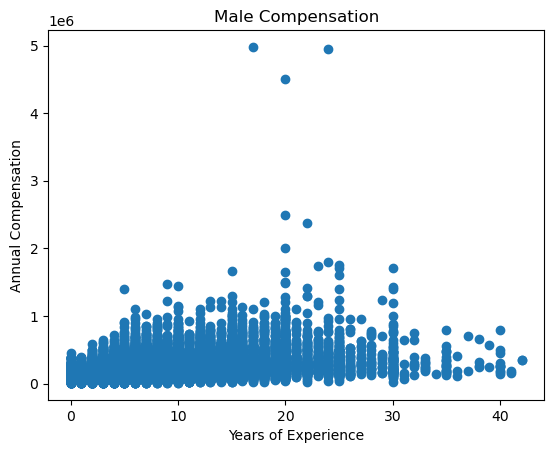

Number of males: 34749


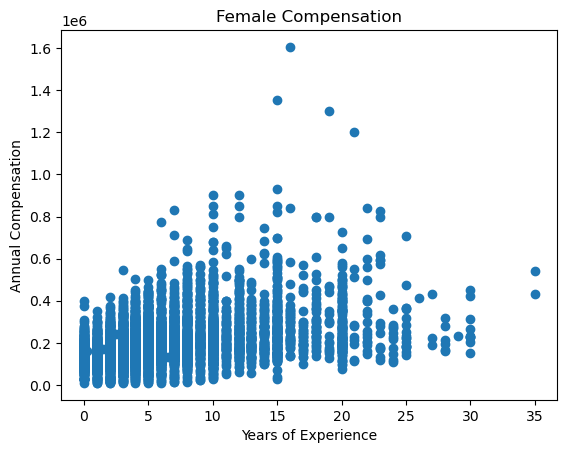

Number of females: 6252


In [141]:
df_show = df_sex[df_sex['Male'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Male Compensation')
plt.show()
print('Number of males: ' + str(df_show.shape[0]))

df_show = df_sex[df_sex['Female'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Female Compensation')
plt.show()
print('Number of females: ' + str(df_show.shape[0]))

There does not seem to be a purely visible correlation between genders and pay, and no real relationship within genders and years of experience. In fact, female compensation across all years of experience seems to trend higher, but this could be a result of there being so fewer declared females compared to males. With this context, we can proceed with a linear regression model that will be trained using the Ordinary Least Squares (OLS) method using 5-fold cross validation to minimize the residual sum of squares error (RSS). Then, the weights associated with the minimum RSS will be used to predict compensation across all samples.

In [142]:
# Function assumes that the dependent variable (labels, y, etc.) is the final column of the array
def ols_five(data, folds=5):
    shuf = data.copy().sample(frac = 1)
    x_num = shuf.shape[1] - 1
    x_train, y_train = shuf.values[:, :x_num], shuf.values[:, -1]

    features = x_train.astype(float)
    labels = y_train.astype(float)
    
    features_split = np.array_split(features, folds)
    labels_split = np.array_split(labels, folds)

    w_models = []
    rss_errors = np.zeros(5).astype(float)

    for i in range(folds):
        old_x = features_split[i]
        x = np.ones(shape=(old_x.shape[0], old_x.shape[1] + 1)) # Array of ones with one additional column for base weight
        x[:, 1:] = old_x # Replace non-first columns with features
        y = labels_split[i]
        xt = np.transpose(x) # X^T
        xty = np.dot(xt, y) # X^T * y
        xtx = np.dot(xt, x) # X^T * X
        xtx_1 = np.linalg.pinv(xtx) # (X^T * X)^-1
        w = np.dot(xtx_1, xty) # (X^T * X)^-1 * (X^T * y)
        w_models.append(w)

        # Isolate validation set for RSS calcs
        # x = features[start:end]
        # y = labels[start:end]
        y_xw = y - (np.dot(x, w)) # y - Xw
        y_xw_t = np.transpose(y_xw) # (y - Xw)^T
        rss_w = np.dot(y_xw_t, y_xw) # (y - Xw)^T * (y - Xw)

        sqrt_rss_w = rss_w ** (1/2) # sqrt of RSS
        rss_errors[i] = sqrt_rss_w
        print('The square root RSS of fold ' + str(i + 1) + ' = ' + str(rss_errors[i]))

    min_arg = np.argmin(rss_w)
    min_w = w_models[min_arg]
    return min_w, features

# Simple matrix multiplication to apply calculated weights to samples and yield predicted y
def get_preds(weights, features):
    n, d = features.shape
    d_plus_one = d + 1
    
    aug_features = np.ones(shape=(n, d_plus_one))
    aug_features[:, 1:] = features
    
    return np.dot(aug_features, weights)

weights, features = ols_five(df_sex, 5)

print('Intercept: ', weights[0])
print('Coefficients: ', weights[1:])

df_show = df_sex.copy()
df_show['Predicted Compensation'] = get_preds(weights, features)
df_show

The square root RSS of fold 1 = 10809616.322579928
The square root RSS of fold 2 = 10289448.988504795
The square root RSS of fold 3 = 10801775.642381819
The square root RSS of fold 4 = 11746998.800976835
The square root RSS of fold 5 = 12051188.606816152
Intercept:  96358.22484979688
Coefficients:  [50173.19822 46185.02663 10356.36577 -2881.38346]


,Male,Female,Years of Experience,Years at Company,Annual Compensation,Predicted Compensation
264,1,0,4.0,4.0,140000,177600.520376
265,1,0,12.0,2.0,172000,168956.370010
266,1,0,7.0,2.0,325000,187956.886146
269,1,0,4.0,0.0,150000,252412.723439
270,1,0,11.0,4.0,640000,187956.886146
...,...,...,...,...,...,...
62610,1,0,1.0,0.0,135000,290351.375789
62611,1,0,14.0,1.0,350000,164362.771151
62612,0,1,20.0,2.0,305000,167244.154607
62613,1,0,3.0,0.0,152000,154006.405382


The number of years spent at a company seems to be slightly negatively correlated overall. This may be because of the high rate of turnover that is common in the tech industry making this metric particularly unhelpful. The difference between male and female compensation appears to be approximately \$5000 if all other variables held constant (across several runs since the data frame is shuffled each time). While it is unfortunate that there aren't more "objective" qualifiers, these results in isolation do indicate a gap in pay that favors men.

Next, we will enlist the statsmodel library to build a separate linear regression model and verify the above findings.

In [143]:
import statsmodels.api as sm

# OLS without using 5-fold cross validation (to compare against statsmodel)
def ols(data):
    x_num = data.shape[1] - 1
    x_train, y_train = data.values[:, :x_num], data.values[:, -1]

    features = x_train.astype(float)
    labels = y_train.astype(float)
    
    x = np.ones(shape=(features.shape[0], features.shape[1] + 1)) # Array of ones with one additional column for base weight
    x[:, 1:] = features # Replace non-first columns with features
    y = labels
    xt = np.transpose(x) # X^T
    xty = np.dot(xt, y) # X^T * y
    xtx = np.dot(xt, x) # X^T * X
    xtx_1 = np.linalg.pinv(xtx) # (X^T * X)^-1
    w = np.dot(xtx_1, xty) # (X^T * X)^-1 * (X^T * y)
    return w

weights = ols(df_sex)

print('Intercept: ', weights[0])
print('Coefficients: ', weights[1:])

x = df_sex[['Male', 'Female', 'Years of Experience', 'Years at Company']].astype(float)
y = df_sex['Annual Compensation'].astype(float)

x = sm.add_constant(x) # Add column of ones
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print(model.summary())

Intercept:  96864.0367323441
Coefficients:  [49110.67965 47753.35708 10415.78448 -2974.19099]
                             OLS Regression Results                            
Dep. Variable:     Annual Compensation   R-squared:                       0.174
Model:                             OLS   Adj. R-squared:                  0.174
Method:                  Least Squares   F-statistic:                     2872.
Date:                 Sun, 07 May 2023   Prob (F-statistic):               0.00
Time:                         19:52:30   Log-Likelihood:            -5.3879e+05
No. Observations:                41001   AIC:                         1.078e+06
Df Residuals:                    40997   BIC:                         1.078e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------

The results of the model from the statsmodel API is analagous to the results from the non-validated OLS function. It also reinforces that years at the company is a poor metric, and that the gap in pay still exists in a relatively non-trivial amount.

With gender covered, the next step is to repeat these observations using race as the distinguishing metric.

In [144]:
one_hot_race = pd.get_dummies(df['Race'])
df_race = df.drop('Race', axis = 1)
df_race = one_hot_race.join(df_race)
df_race = df_race[(df_race['White'] == 1) | (df_race['Black'] == 1)
                 | (df_race['Asian'] == 1) | (df_race['Hispanic'] == 1)]
df_race = df_race.drop('Unknown', axis = 1)
df_race = df_race.drop('Two Or More', axis = 1)
df_race = df_race[['White', 'Black', 'Asian', 'Hispanic', 'Years of Experience', 'Years at Company', 'Annual Compensation']]
df_race

,White,Black,Asian,Hispanic,Years of Experience,Years at Company,Annual Compensation
6921,1,0,0,0,7.0,2.0,310000
8366,0,0,1,0,14.0,3.0,200000
10937,0,1,0,0,2.0,1.0,103000
11997,0,0,1,0,6.0,2.0,170000
14429,0,0,1,0,1.0,1.0,134000
...,...,...,...,...,...,...,...
61982,0,0,1,0,20.0,14.0,4500000
61984,1,0,0,0,16.0,2.0,1605000
61986,0,0,1,0,15.0,15.0,1660000
61987,0,1,0,0,22.0,2.0,2372000


Let's repeat the simplistic analysis through the known single race classifiers.

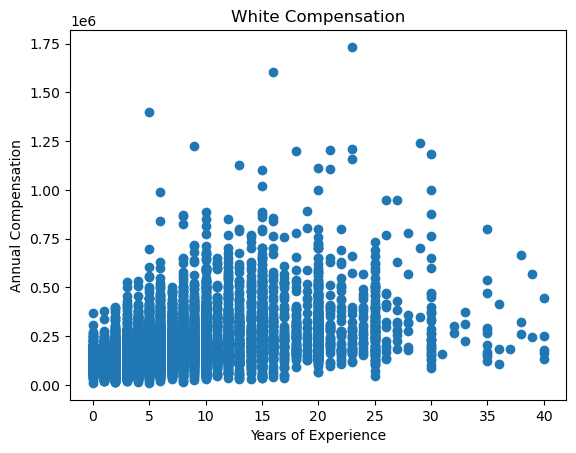

Number of white employees: 7334


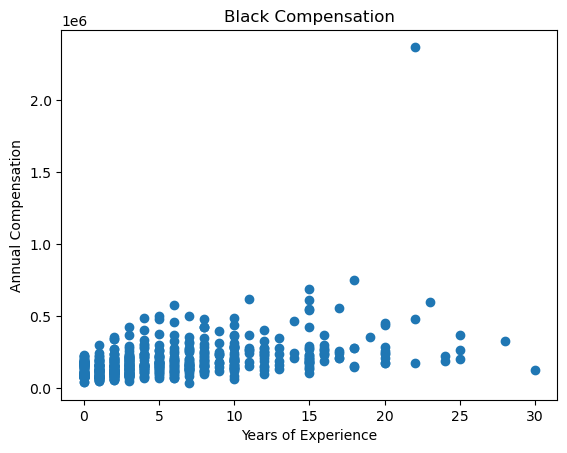

Number of black employees: 585


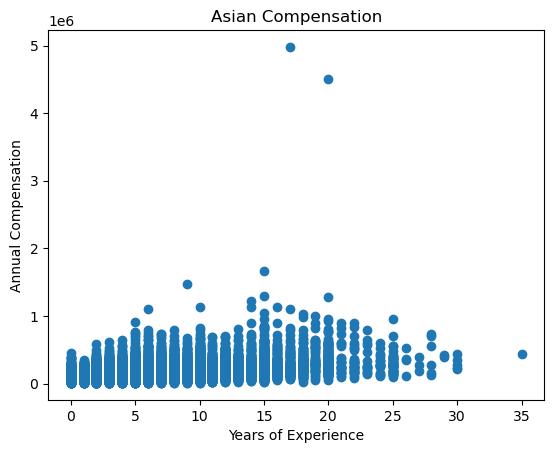

Number of asian employees: 11286


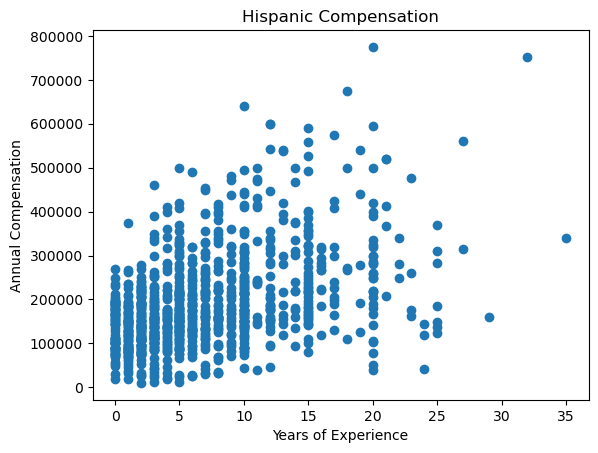

Number of hispanic employees: 1027


In [145]:
df_show = df_race[df_race['White'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('White Compensation')
plt.show()
print('Number of white employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Black'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Black Compensation')
plt.show()
print('Number of black employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Asian'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Asian Compensation')
plt.show()
print('Number of asian employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Hispanic'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Hispanic Compensation')
plt.show()
print('Number of hispanic employees: ' + str(df_show.shape[0]))

Again, there is little correlation here between the only truly objective metric available in this data set. We must proceed with linear regression to identify which features weigh the most on predicting compensation.

In [146]:
weights, features = ols_five(df_race, 5)

print('Intercept: ', weights[0])
print('Coefficients: ', weights[1:])

df_show = df_race.copy()
df_show['Predicted Compensation'] = get_preds(weights, features)
df_show

The square root RSS of fold 1 = 7130259.09555029
The square root RSS of fold 2 = 7510244.526924775
The square root RSS of fold 3 = 8650793.97871887
The square root RSS of fold 4 = 8307014.2389859455
The square root RSS of fold 5 = 7563163.257245785
Intercept:  107233.60471950247
Coefficients:  [29357.25092 23492.36389 27587.63738 26796.35253  9679.99809 -2203.13232]


,White,Black,Asian,Hispanic,Years of Experience,Years at Company,Annual Compensation,Predicted Compensation
6921,1,0,0,0,7.0,2.0,310000,134821.242103
8366,0,0,1,0,14.0,3.0,200000,210058.094467
10937,0,1,0,0,2.0,1.0,103000,163069.951504
11997,0,0,1,0,6.0,2.0,170000,308159.494139
14429,0,0,1,0,1.0,1.0,134000,298947.690775
...,...,...,...,...,...,...,...,...
61982,0,0,1,0,20.0,14.0,4500000,280021.213389
61984,1,0,0,0,16.0,2.0,1605000,202113.033982
61986,0,0,1,0,15.0,15.0,1660000,142298.107867
61987,0,1,0,0,22.0,2.0,2372000,136590.855639


Again, years at a company seems to have a slight negative correlation, and each year of experience seems to increase compensation on average by around \$9000 across separate runs. Unfortunately, the results across racial groups have proven to be very inconsistent across different runs. Although the above cell in this notebook may reflect a certain scenario, the weights changed **dramatically** across different runs to the point that we may have to disregard the results.

Once again, the nature of these results will be verified through the statsmodel API, and hopefully the weights across the totality of the dataset may yield a more fruitful result than the above.

In [147]:
w = ols(df_race)

print('Intercept: ', weights[0])
print('Coefficients: ', weights[1:])
print('\n\n')

x = df_race[['White', 'Black', 'Asian', 'Hispanic', 'Years of Experience', 'Years at Company']].astype(float)
y = df_race['Annual Compensation'].astype(float)
x = sm.add_constant(x) # Add column of ones
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print(model.summary())

Intercept:  107233.60471950247
Coefficients:  [29357.25092 23492.36389 27587.63738 26796.35253  9679.99809 -2203.13232]



                             OLS Regression Results                            
Dep. Variable:     Annual Compensation   R-squared:                       0.162
Model:                             OLS   Adj. R-squared:                  0.162
Method:                  Least Squares   F-statistic:                     783.3
Date:                 Sun, 07 May 2023   Prob (F-statistic):               0.00
Time:                         19:52:32   Log-Likelihood:            -2.6592e+05
No. Observations:                20232   AIC:                         5.318e+05
Df Residuals:                    20226   BIC:                         5.319e+05
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025  

Across the totality of the data, it appears that black employees seem to make on average the most, while Hispanic employees make dramatically less than the other groups. However, once again this could be explained by the relative lack of black and Hispanic employees across the totality of the data (there were only 585 black employees).

Overall, the explanatory power of this data is muddied. There aren't any significant indicators of a gap in compensation across races that could not also be potentially be explained by dramatically undersampled groups, particularly given much of the data was culled since their identifying characteristics were not collected. There *does* seem to be a reproducable gap in average compensation that favors men over women, but beyond that it is difficult to grasp other patterns.

## Jim

In this section of the notebook, we'll make a callback to the EEOC data source, HRDataset_v13.csv, to see if there are any trends that form relative to Race for the current population. The amount of samples within the dataset is pretty limited so we'll take a look at the mean scores for yearly Performance and Engagement Surveys, and we'll add in the Pay Rate for our analysis as well.

In [148]:
# Re-import the Human Resources Dataset 
df = pd.read_csv('inputs/HRDataset_v13.csv')
df.dropna(how='all', inplace=True)
df.RaceDesc.name = 'Racial Group'
# This creates a list a columns that we're interested in seeing.
relevant_info_mean = ['RaceDesc','PerfScoreID','EngagementSurvey','PayRate']
# This aggregates the values by Race, counts the number of representations within each Race, and caculates the mean values for the features we're concerned about.
display(df[relevant_info_mean].groupby("RaceDesc").agg(Count=('PerfScoreID', 'count'),Mean_PerfScoreID=('PerfScoreID', 'mean'), Mean_EngagementSurvey=('EngagementSurvey', 'mean'), Mean_PayRate=('PayRate', 'mean')).reset_index())


,RaceDesc,Count,Mean_PerfScoreID,Mean_EngagementSurvey,Mean_PayRate
0,American Indian or Alaska Native,4,3.500000,3.150000,30.375000
1,Asian,34,3.000000,2.870588,31.357647
2,Black or African American,57,2.912281,3.332982,35.346140
3,Hispanic,4,2.750000,2.762500,39.750000
4,Two or more races,18,2.944444,3.292778,31.264444
5,White,193,3.000000,3.432383,29.917824


Something of importance here is that the scale of Performance Scores range from 1 to 5, where 1 is the worst and 5 is the best. While it is interesting to see how this data breaks out relative to race, we aren't able to pull any strong insights from the data. There doesn't seem to be any strong correlations between features like performance scores and pay rate. Comparing ***American Indian or Alaska Native*** to ***Hispanic***, for example, shows that the mean pay rate for Hispanics is higher than that of American Indian or Alaska Native, but the mean performance of ***Hispanics*** is lower than that of ***American Indian or Alaska Native*** (the engagement scores also follow this trend). Conventional wisdom would lead one to believe that lower performance results in lower pay assuming everyone starts at the same base pay rate. But the absence of geographical information, that could explain a difference in pay relative to cost of living, means we can't be sure that discrimination is to blame.

This next portion will utilize sklearn's Linear Regression modeling capabilities with salary data from Levels FYI (the same data used earlier by Chris). We'll attempt to predict the annual compensation for male and female samples, as well as by race. Then we'll visually compare the predicted income by gender and then by race to see how they fare. First up, gender comparisons.

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# We cap the income at 800k to exlude major outliers to help improve the accuracy of predictions.
# This tends to impact the population of white male workers.
maximum_annual_compensation = 800000 

df = pd.read_csv('inputs/Levels_Fyi_Salary_Data.csv')
df = df[['gender', 'Race', 'company', 'title', 'yearsofexperience', 
         'yearsatcompany', 'Education', 'totalyearlycompensation']]
df = df.fillna({'gender':'Unknown', 'Race':'Unknown', 'company':'Unknown', 'Education':'Unknown'})
df = df.rename(columns = {'gender':'Gender', 'company':'Company', 'title':'Position', 
                          'yearsofexperience':'Years of Experience', 'yearsatcompany':'Years at Company', 
                          'totalyearlycompensation':'Annual Compensation'})
df['Position'].unique()
df = df[(df['Position'].str.contains('Human Resources') == False)]
df = df[(df['Position'].str.contains('Marketing') == False)]
df = df[(df['Position'].str.contains('Business Analyst') == False)]
df = df[(df['Position'].str.contains('Sales') == False)]
df = df[(df['Position'].str.contains('Recruiter') == False)]

one_hot_gender = pd.get_dummies(df['Gender'])
df_sex = df.drop('Gender', axis = 1)
df_sex = one_hot_gender.join(df_sex)
df_sex = df_sex[(df_sex['Male'] == 1) | (df_sex['Female'] == 1)]
df_sex = df_sex.drop('Other', axis = 1)
df_sex = df_sex.drop('Title: Senior Software Engineer', axis = 1)
df_sex = df_sex.drop('Unknown', axis = 1)
df_sex = df_sex[['Male', 'Female', 'Years of Experience', 'Years at Company', 'Annual Compensation']]

df_males = df_sex[(df_sex['Male'] == 1) & (df_sex['Annual Compensation'] <= maximum_annual_compensation)]
df_females = df_sex[(df_sex['Female'] == 1) & (df_sex['Annual Compensation'] <= maximum_annual_compensation)]



In [150]:
def new_func(x_train, x_test, y_train, y_test,group):
    plt.scatter(x_train,y_train)
    plt.scatter(x_test,y_test)
    LR = LinearRegression()
    LR.fit(x_train.values.reshape(-1,1),y_train.values)
    prediction = LR.predict(x_test.values.reshape(-1,1))
    plt.plot(x_test, prediction, label='Linear Regression Model for Males')
    plt.scatter(x_test, y_test, label ='Actual Test Data')
    plt.show()
    print("Linear Regression Score for "+ group +": "+str(LR.score(x_test.values.reshape(-1,1),y_test.values)))
    return LR

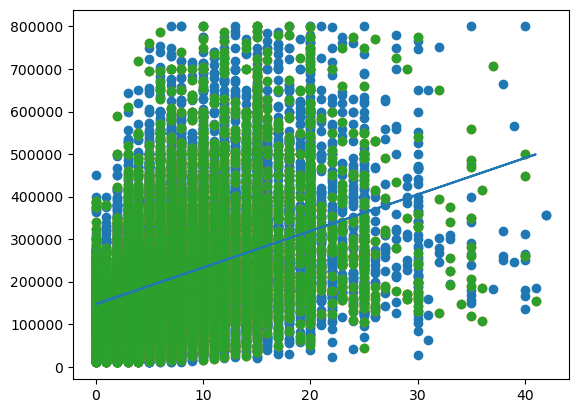

Linear Regression Score for males: 0.17777058806931267


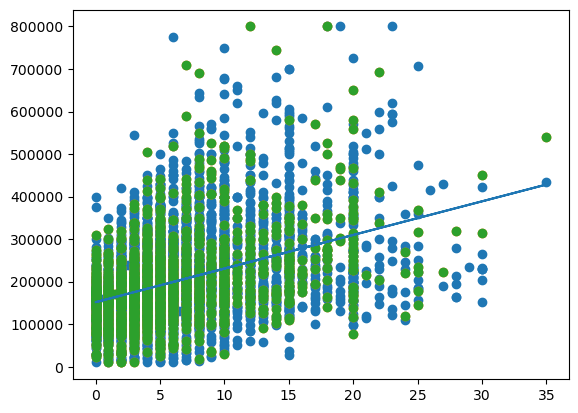

Linear Regression Score for females: 0.18613327172143534

Predicted Annual Compensation for Males after 0 years: $ 147,054.46
Predicted Annual Compensation for Females after 0 years: $ 151,699.42

Predicted Annual Compensation for Males after 10 years: $ 232,982.93
Predicted Annual Compensation for Females after 10 years: $ 230,761.09

Predicted Annual Compensation for Males after 20 years: $ 318,911.40
Predicted Annual Compensation for Females after 20 years: $ 309,822.75

Predicted Annual Compensation for Males after 30 years: $ 404,839.87
Predicted Annual Compensation for Females after 30 years: $ 388,884.41



In [151]:
# Linear Regeression Model for Males
x_train_male, x_test_male, y_train_male, y_test_male = train_test_split(df_males['Years of Experience'],df_males['Annual Compensation'])

LR_males = new_func(x_train_male, x_test_male, y_train_male, y_test_male,"males")

# Linear Regression Models for Females
x_train_female, x_test_female, y_train_female, y_test_female = train_test_split(df_females['Years of Experience'],df_females['Annual Compensation'])
LR_females = new_func(x_train_female, x_test_female, y_train_female, y_test_female,"females")

print("")
for years in range(0, 31, 10):
    print(f"Predicted Annual Compensation for Males after {years} years: $ {LR_males.predict(np.array([[years]]))[0]:,.2f}")
    print(f"Predicted Annual Compensation for Females after {years} years: $ {LR_females.predict(np.array([[years]]))[0]:,.2f}\n")

We can see that our prediction at 0 years of experience shows that men are paid less than women. However, 10 years and beyond show men overtaking women in annual compensation. The difference between gender over time is pretty striking as the gap continues to widen for the equivalent years of experience.

Next, we'll take a look at predicting annual compensation based on race. We'll use the same maximum annual compensation cap of 800k here.

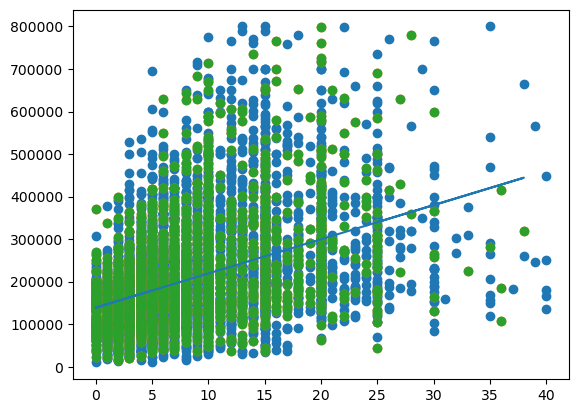

Linear Regression Score for white workers: 0.1999365345340992


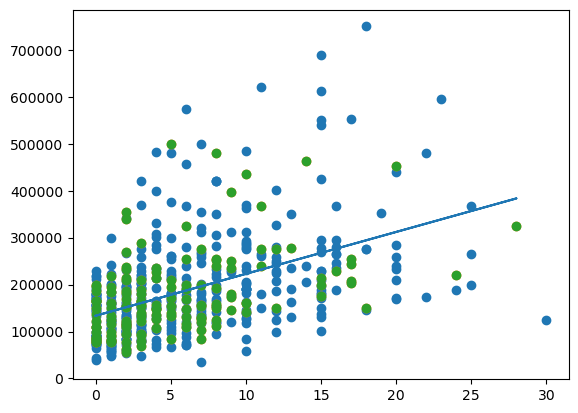

Linear Regression Score for black workers: 0.19821321720746332


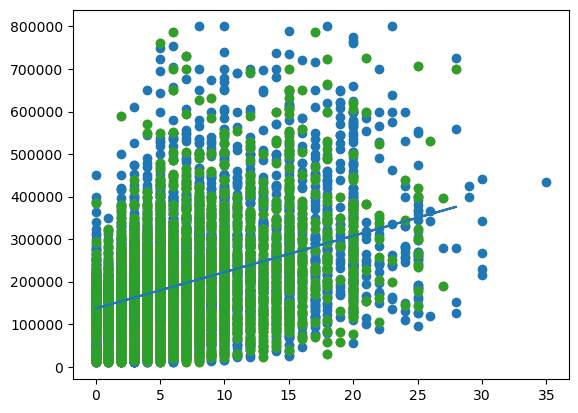

Linear Regression Score for asian workers: 0.12943546834190922


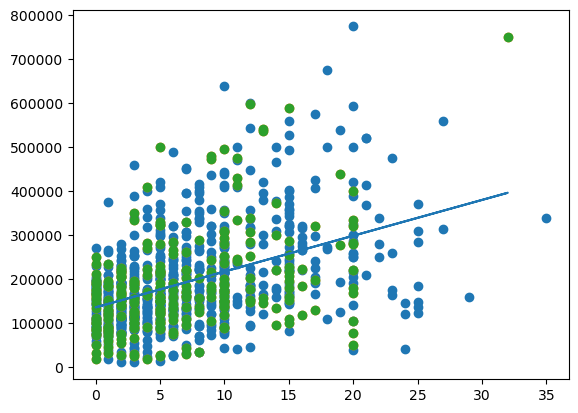

Linear Regression Score for hispanic workers: 0.18481420407536664

Predicted Annual Compensation for white workers after 0 years: $ 138,855.71
Predicted Annual Compensation for black workers after 0 years: $ 133,510.89
Predicted Annual Compensation for asian workers after 0 years: $ 136,865.04
Predicted Annual Compensation for hispanic workers after 0 years: $ 135,407.59

Predicted Annual Compensation for white workers after 10 years: $ 219,259.92
Predicted Annual Compensation for black workers after 10 years: $ 222,829.62
Predicted Annual Compensation for asian workers after 10 years: $ 222,321.93
Predicted Annual Compensation for hispanic workers after 10 years: $ 216,963.35

Predicted Annual Compensation for white workers after 20 years: $ 299,664.13
Predicted Annual Compensation for black workers after 20 years: $ 312,148.34
Predicted Annual Compensation for asian workers after 20 years: $ 307,778.82
Predicted Annual Compensation for hispanic workers after 20 years: $ 298,519.10

P

In [152]:
one_hot_race = pd.get_dummies(df['Race'])
df_race = df.drop('Race', axis = 1)
df_race = one_hot_race.join(df_race)
df_race = df_race[(df_race['White'] == 1) | (df_race['Black'] == 1)
                 | (df_race['Asian'] == 1) | (df_race['Hispanic'] == 1)]
df_race = df_race.drop('Unknown', axis = 1)
df_race = df_race.drop('Two Or More', axis = 1)
df_race = df_race[['White', 'Black', 'Asian', 'Hispanic', 'Years of Experience', 'Years at Company', 'Annual Compensation']]

df_white = df_race[(df_race['White'] == 1) & (df_race['Annual Compensation'] <= maximum_annual_compensation)]

df_black = df_race[(df_race['Black'] == 1) & (df_race['Annual Compensation'] <= maximum_annual_compensation)]


df_Asian = df_race[(df_race['Asian'] == 1) & (df_race['Annual Compensation'] <= maximum_annual_compensation)]

df_Hispanic = df_race[(df_race['Hispanic'] == 1) & (df_race['Annual Compensation'] <= maximum_annual_compensation)]


x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(df_white['Years of Experience'],df_white['Annual Compensation'])
LR_white = new_func(x_train_white, x_test_white, y_train_white, y_test_white,"white workers")

x_train_black, x_test_black, y_train_black, y_test_black = train_test_split(df_black['Years of Experience'],df_black['Annual Compensation'])
LR_black = new_func(x_train_black, x_test_black, y_train_black, y_test_black,"black workers")

x_train_asian, x_test_asian, y_train_asian, y_test_asian = train_test_split(df_Asian['Years of Experience'],df_Asian['Annual Compensation'])
LR_asian = new_func(x_train_asian, x_test_asian, y_train_asian, y_test_asian,"asian workers")

x_train_hispanic, x_test_hispanic, y_train_hispanic, y_test_hispanic = train_test_split(df_Hispanic['Years of Experience'],df_Hispanic['Annual Compensation'])
LR_hispanic = new_func(x_train_hispanic, x_test_hispanic, y_train_hispanic, y_test_hispanic,"hispanic workers")


print("")
for years in range(0, 31, 10):
    print(f"Predicted Annual Compensation for white workers after {years} years: $ {LR_white.predict(np.array([[years]]))[0]:,.2f}")
    print(f"Predicted Annual Compensation for black workers after {years} years: $ {LR_black.predict(np.array([[years]]))[0]:,.2f}")
    print(f"Predicted Annual Compensation for asian workers after {years} years: $ {LR_asian.predict(np.array([[years]]))[0]:,.2f}")
    print(f"Predicted Annual Compensation for hispanic workers after {years} years: $ {LR_hispanic.predict(np.array([[years]]))[0]:,.2f}")
    print("")



Here we see a prediction that white and Asian workers at year 0 are paid more than black and Hispanic. However, by 10 years of experience, we see that black workers are paid the most and that trend continues to grow by year 30. Interesting to note that white, Asian, and Hispanic workers are paid relatively the same amount in our prediction by 30 years of experience.

## Rohit

Section analyzes a small campus placement dataset. The purpose of this notebook is to see a clear bias of campus recruitment between two genders, male and female, based on attributes such as, degree type, undergraduate degree percentage, mba percentage, and most importantly salary distribution between the two genders.

In [153]:
# Campus Recruitment Data
# 'inputs/Placement_Data_Full_Class.csv' <- Directory for Github

# necessary imports
from tqdm import tqdm
import numpy as np
%matplotlib inline

# load data from csv file
dataframe = pd.read_csv('inputs/Placement_Data_Full_Class.csv')
dataframe.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


After loading the data, we will now drop unnecessary attributes like "serial number", "secondary education percentage", "board of education", etc. 

In [154]:
# drop/shave off attributes deemed not necessary
dataframe.drop(['sl_no','hsc_s','hsc_b','ssc_b','ssc_p','hsc_p','specialisation','etest_p','workex'],axis=1,inplace=True)
display(dataframe)

,gender,degree_p,degree_t,mba_p,status,salary
0,M,58.00,Sci&Tech,58.80,Placed,270000.0
1,M,77.48,Sci&Tech,66.28,Placed,200000.0
2,M,64.00,Comm&Mgmt,57.80,Placed,250000.0
3,M,52.00,Sci&Tech,59.43,Not Placed,NaN
4,M,73.30,Comm&Mgmt,55.50,Placed,425000.0
...,...,...,...,...,...,...
210,M,77.60,Comm&Mgmt,74.49,Placed,400000.0
211,M,72.00,Sci&Tech,53.62,Placed,275000.0
212,M,73.00,Comm&Mgmt,69.72,Placed,295000.0
213,F,58.00,Comm&Mgmt,60.23,Placed,204000.0


We will apply label encoding to attributes such as "gender", "degree type", and "status". We will also fill in 'NaN' values in "salary" with '0.0' to considered non-placed candidates within our dataset.

In [155]:
# applying label encoding
dataframe.replace('M', 0.0, inplace=True)
dataframe.replace('F', 1.0, inplace=True)
dataframe.replace('Sci&Tech', 0.0, inplace=True)
dataframe.replace('Comm&Mgmt', 1.0, inplace=True)
dataframe.replace('Others', 2.0, inplace=True)
dataframe.salary.fillna(value=0,inplace=True)
dataframe.replace('Placed', 0.0, inplace=True)
dataframe.replace('Not Placed', 1.0, inplace=True)
display(dataframe)

,gender,degree_p,degree_t,mba_p,status,salary
0,0.0,58.00,0.0,58.80,0.0,270000.0
1,0.0,77.48,0.0,66.28,0.0,200000.0
2,0.0,64.00,1.0,57.80,0.0,250000.0
3,0.0,52.00,0.0,59.43,1.0,0.0
4,0.0,73.30,1.0,55.50,0.0,425000.0
...,...,...,...,...,...,...
210,0.0,77.60,1.0,74.49,0.0,400000.0
211,0.0,72.00,0.0,53.62,0.0,275000.0
212,0.0,73.00,1.0,69.72,0.0,295000.0
213,1.0,58.00,1.0,60.23,0.0,204000.0


We will now separate features based on the ground truth labels, and set up our training and validation sets.

In [156]:
# split into features and labels
features = dataframe.values[:, 1:]
labels = dataframe.values[:, -1].astype(int)
print('array of labels: shape', np.shape(labels))
print('array of feature matrix: shape', np.shape(features))

array of labels: shape (215,)
array of feature matrix: shape (215, 5)


In [157]:
# split into validation and training features
val_features, train_features = np.split(features, [int(0.2 * features.shape[0])])
val_labels, train_labels = np.split(labels, [int(0.2 * labels.shape[0])])

# print shapes
print('Training features: shape', np.shape(train_features))
print('Validation features: shape', np.shape(val_features))
print('Training labels: shape', np.shape(train_labels))
print('Validation labels: shape', np.shape(val_labels))

Training features: shape (172, 5)
Validation features: shape (43, 5)
Training labels: shape (172,)
Validation labels: shape (43,)


Next, we will do a KNN classification with 2 nearest neighbors, and print out the prediction labels and its shape.

In [158]:
### GRADER PLEASE READ ###

# CITATION: Function is partially extracted from Professor Zhu from HW1 solution
# REASON: We opted to not use sklearn and wanted to use an implementation
# where we can change parts of the function for our needs, and not risk
# the accuracy of our results, ultimately maximizing efficiency.

def knn(train_features, train_labels, test_features, k=2):
    validation_predictions = []
    for i in tqdm(range(test_features.shape[0])):
        features = test_features[i, :]  
        euclidean = np.sum(np.abs(features - train_features), axis=1)
        index = np.argpartition(euclidean, k)[:k]
        near = list(train_labels[index])
        prediction = max(near, key=near.count)
        validation_predictions.append(prediction)
    return np.array(validation_predictions)

val_preds = knn(train_features, train_labels, val_features)
print(val_preds)
print('Prediction labels: shape', val_preds.shape)

100%|██████████| 43/43 [00:00<00:00, 8690.97it/s]

[270000 200000 250000      0 420000      0      0 252000 230000      0
 260000 250000      0 218000      0 200000 300000      0      0 236000
 265000 400000 360000 300000 360000      0 240000 265000 350000      0
 250000      0 280000 260000      0 300000      0 336000 240000 420000
 285000      0      0]
Prediction labels: shape (43,)


Finally, we will now evaluate our prediction labels using the following metrics, accuracy, micro F1 and macro F1 scores.

In [159]:
### GRADER PLEASE READ ###

# CITATION: Function extracted from Professor Zhu from HW1 solution
# REASON: We opted to not use sklearn and wanted to use an implemention
# where we can change things as we see, while not risking accuracy,
# ultimately maximizing efficiency.

def results(true, pred):
    accuracy = (np.sum(pred == true) / len(true))*100
    micro_TP = 0
    micro_FP = 0
    micro_FN = 0
    micro_TN = 0
    macro_F1 = []
    for c in range(6):
        c_label_pos = (true == c)
        c_label_neg = ~c_label_pos
        c_pred_pos = (pred == c)
        c_pred_neg = ~c_pred_pos
        TP = np.sum(c_label_pos * c_pred_pos)
        FP = np.sum(c_label_neg * c_pred_pos)
        FN = np.sum(c_label_pos * c_pred_neg)
        TN = np.sum(c_label_neg * c_pred_neg)
        if TP == 0:
            precision = 0
            recall = 0
            F1 = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            F1 = 2 * precision * recall / (precision + recall)
        macro_F1.append(F1)
        micro_TP += TP
        micro_FP += FP
        micro_TN += TN
        micro_FN += FN
    macro_F1 = (np.mean(macro_F1))*100
    micro_precision = micro_TP / (micro_TP + micro_FP)
    micro_recall = micro_TP / (micro_TP + micro_FN)
    micro_F1 = (2 * micro_precision * micro_recall / (micro_precision + micro_recall))*100
    print(f"Accuracy: {accuracy:.6f}%")
    print(f"Micro F1 score: {micro_F1:.6f}%")
    print(f"Macro F1 score: {macro_F1:.6f}%")
    
results(val_labels, val_preds)

Accuracy: 83.720930%
Micro F1 score: 100.000000%
Macro F1 score: 16.666667%
